In [ ]:
# Example of chaotic migration using dynamical tides operator
import rebound
import reboundx
from matplotlib import pyplot as plt
from reboundx import constants
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 14})

# intial conditions
a0 = 10
e0 = 0.01
R_star = 4.65e-3 # 1 solar radius
R_planet = 1.6 * 4.67e-4 # 1.6 Jupiter radii
m_planet = 0.95e-3 # approximately 1 Jupiter mass

# create simulation
sim = rebound.Simulation()
sim.add(m=1, r = R_star)
sim.add(m=m_planet, r=R_planet, a=a0, e=e0)
sim.add(m=1, a=1600, inc=87.5 * np.pi / 180)
sim.move_to_com()

# load reboundx and the dynamical tides operator
rebx = reboundx.Extras(sim)
#td = rebx.load_force('tides_dynamical')
#rebx.add_force(td)

# load tides_constant_time_lag
time_lag = rebx.load_force("tides_constant_time_lag")
rebx.add_force(time_lag)
sim.particles[0].params['tctl_k2'] = 0.03
sim.particles[1].params['tctl_k2'] = 0.25
sim.particles[1].params['tctl_tau'] = 2*np.pi / (3600*24*365.25) # 1 s

# load gr
gr = rebx.load_force("gr_full")
rebx.add_force(gr)
gr.params["c"] = constants.C

# set dP_crit = 0 to always carry out mode evolution
#sim.particles[1].params['td_dP_crit'] = 0

# set initial modes to 0
#sim.particles[1].params['td_c_imag'] = 0
#sim.particles[1].params['td_c_real'] = 0
#sim.particles[1].params["td_drag_exp"] = 10


# record initial orbital energy
o = sim.particles[1].orbit(primary=sim.particles[0])
EB0 = -sim.G * sim.particles[1].m * sim.particles[0].m / (2 * o.a)

N = 10000
t = np.linspace(0, 2e8, N) # time
a = np.zeros(N) # semi-major axis
a2 = np.zeros(N) # semi-major axis of binary
e2 = np.zeros(N) # semi-major axis of binary
e = np.zeros(N) # eccenricity
E = np.zeros(N) # mode energy
E_sim = np.zeros(N) # simulation energy
L = np.zeros((N, 3)) # total angular momentum
L0 = np.zeros((N, 3))
L1 = np.zeros((N, 3))
L2 = np.zeros((N, 3))
L_manual = np.zeros((N, 3))
comr = np.zeros((N, 3))
comv = np.zeros((N, 3))
inc1 = np.zeros(N)
inc2 = np.zeros(N)
dr = np.zeros(N)

dEs = []
Ms = []

def heartbeat(sim_pointer):
    # read dE if close to pericenter
    sim = sim_pointer.contents
    o = sim.particles[1].orbit(primary=sim.particles[0])

    if sim.particles[1].params['td_num_periapse'] > 1:
        dP_hat = sim.particles[1].params['td_dP_hat']
        M_thresh = 0.1
        if dP_hat >= 1 and ((2*np.pi - o.M) <= M_thresh or o.M <= M_thresh):
            dEs.append(sim.particles[1].params['td_dE_last'])
            Ms.append(o.M)

#sim.heartbeat = heartbeat
for i, time in enumerate(t):
    o = sim.particles[1].orbit(primary=sim.particles[0])
    a[i] = o.a
    e[i] = o.e
    L[i, :] = sim.angular_momentum() 
    #E[i] = abs(EB0) * (sim.particles[1].params['td_c_imag']**2 + sim.particles[1].params['td_c_real']**2)
    
    
    E_sim[i] = sim.energy()

    o2 = sim.particles[2].orbit(primary=sim.particles[0])
    a2[i] = o2.a
    e2[i] = o2.e

    inc1[i] = o.inc
    inc2[i] = o2.inc

    # manually compute angular momentum
    com = sim.com()
    comv[i, :] = np.array([com.vx, com.vy, com.vz])
    comr[i, :] = np.array([com.x, com.y, com.z])
    v1 = np.array([sim.particles[1].vx, sim.particles[1].vy, sim.particles[1].vz]) - comv[i, :]
    r1 = np.array([sim.particles[1].x, sim.particles[1].y, sim.particles[1].z]) - comr[i, :]
    v2 = np.array([sim.particles[2].vx, sim.particles[2].vy, sim.particles[2].vz]) - comv[i, :]
    r2 = np.array([sim.particles[2].x, sim.particles[2].y, sim.particles[2].z]) - comr[i, :]
    v0 = np.array([sim.particles[0].vx, sim.particles[0].vy, sim.particles[0].vz]) - comv[i, :]
    r0 = np.array([sim.particles[0].x, sim.particles[0].y, sim.particles[0].z]) - comr[i, :]

    L_manual[i, :] = sim.particles[0].m * np.cross(r0, v0) + sim.particles[1].m * np.cross(r1, v1) + sim.particles[2].m * np.cross(r2, v2)
    
    if i % 50 == 0 and i != 0 or o.e >= 0.96:
        print(time, o.a, o.e, E[i])#, sim.particles[1].params['td_dP_hat'], sim.particles[1].params['td_drag_coef'])
        
    
    sim.integrate(2 * np.pi * time)
    



1000100.010001 9.999996131318385 0.010063133025683546 0.0


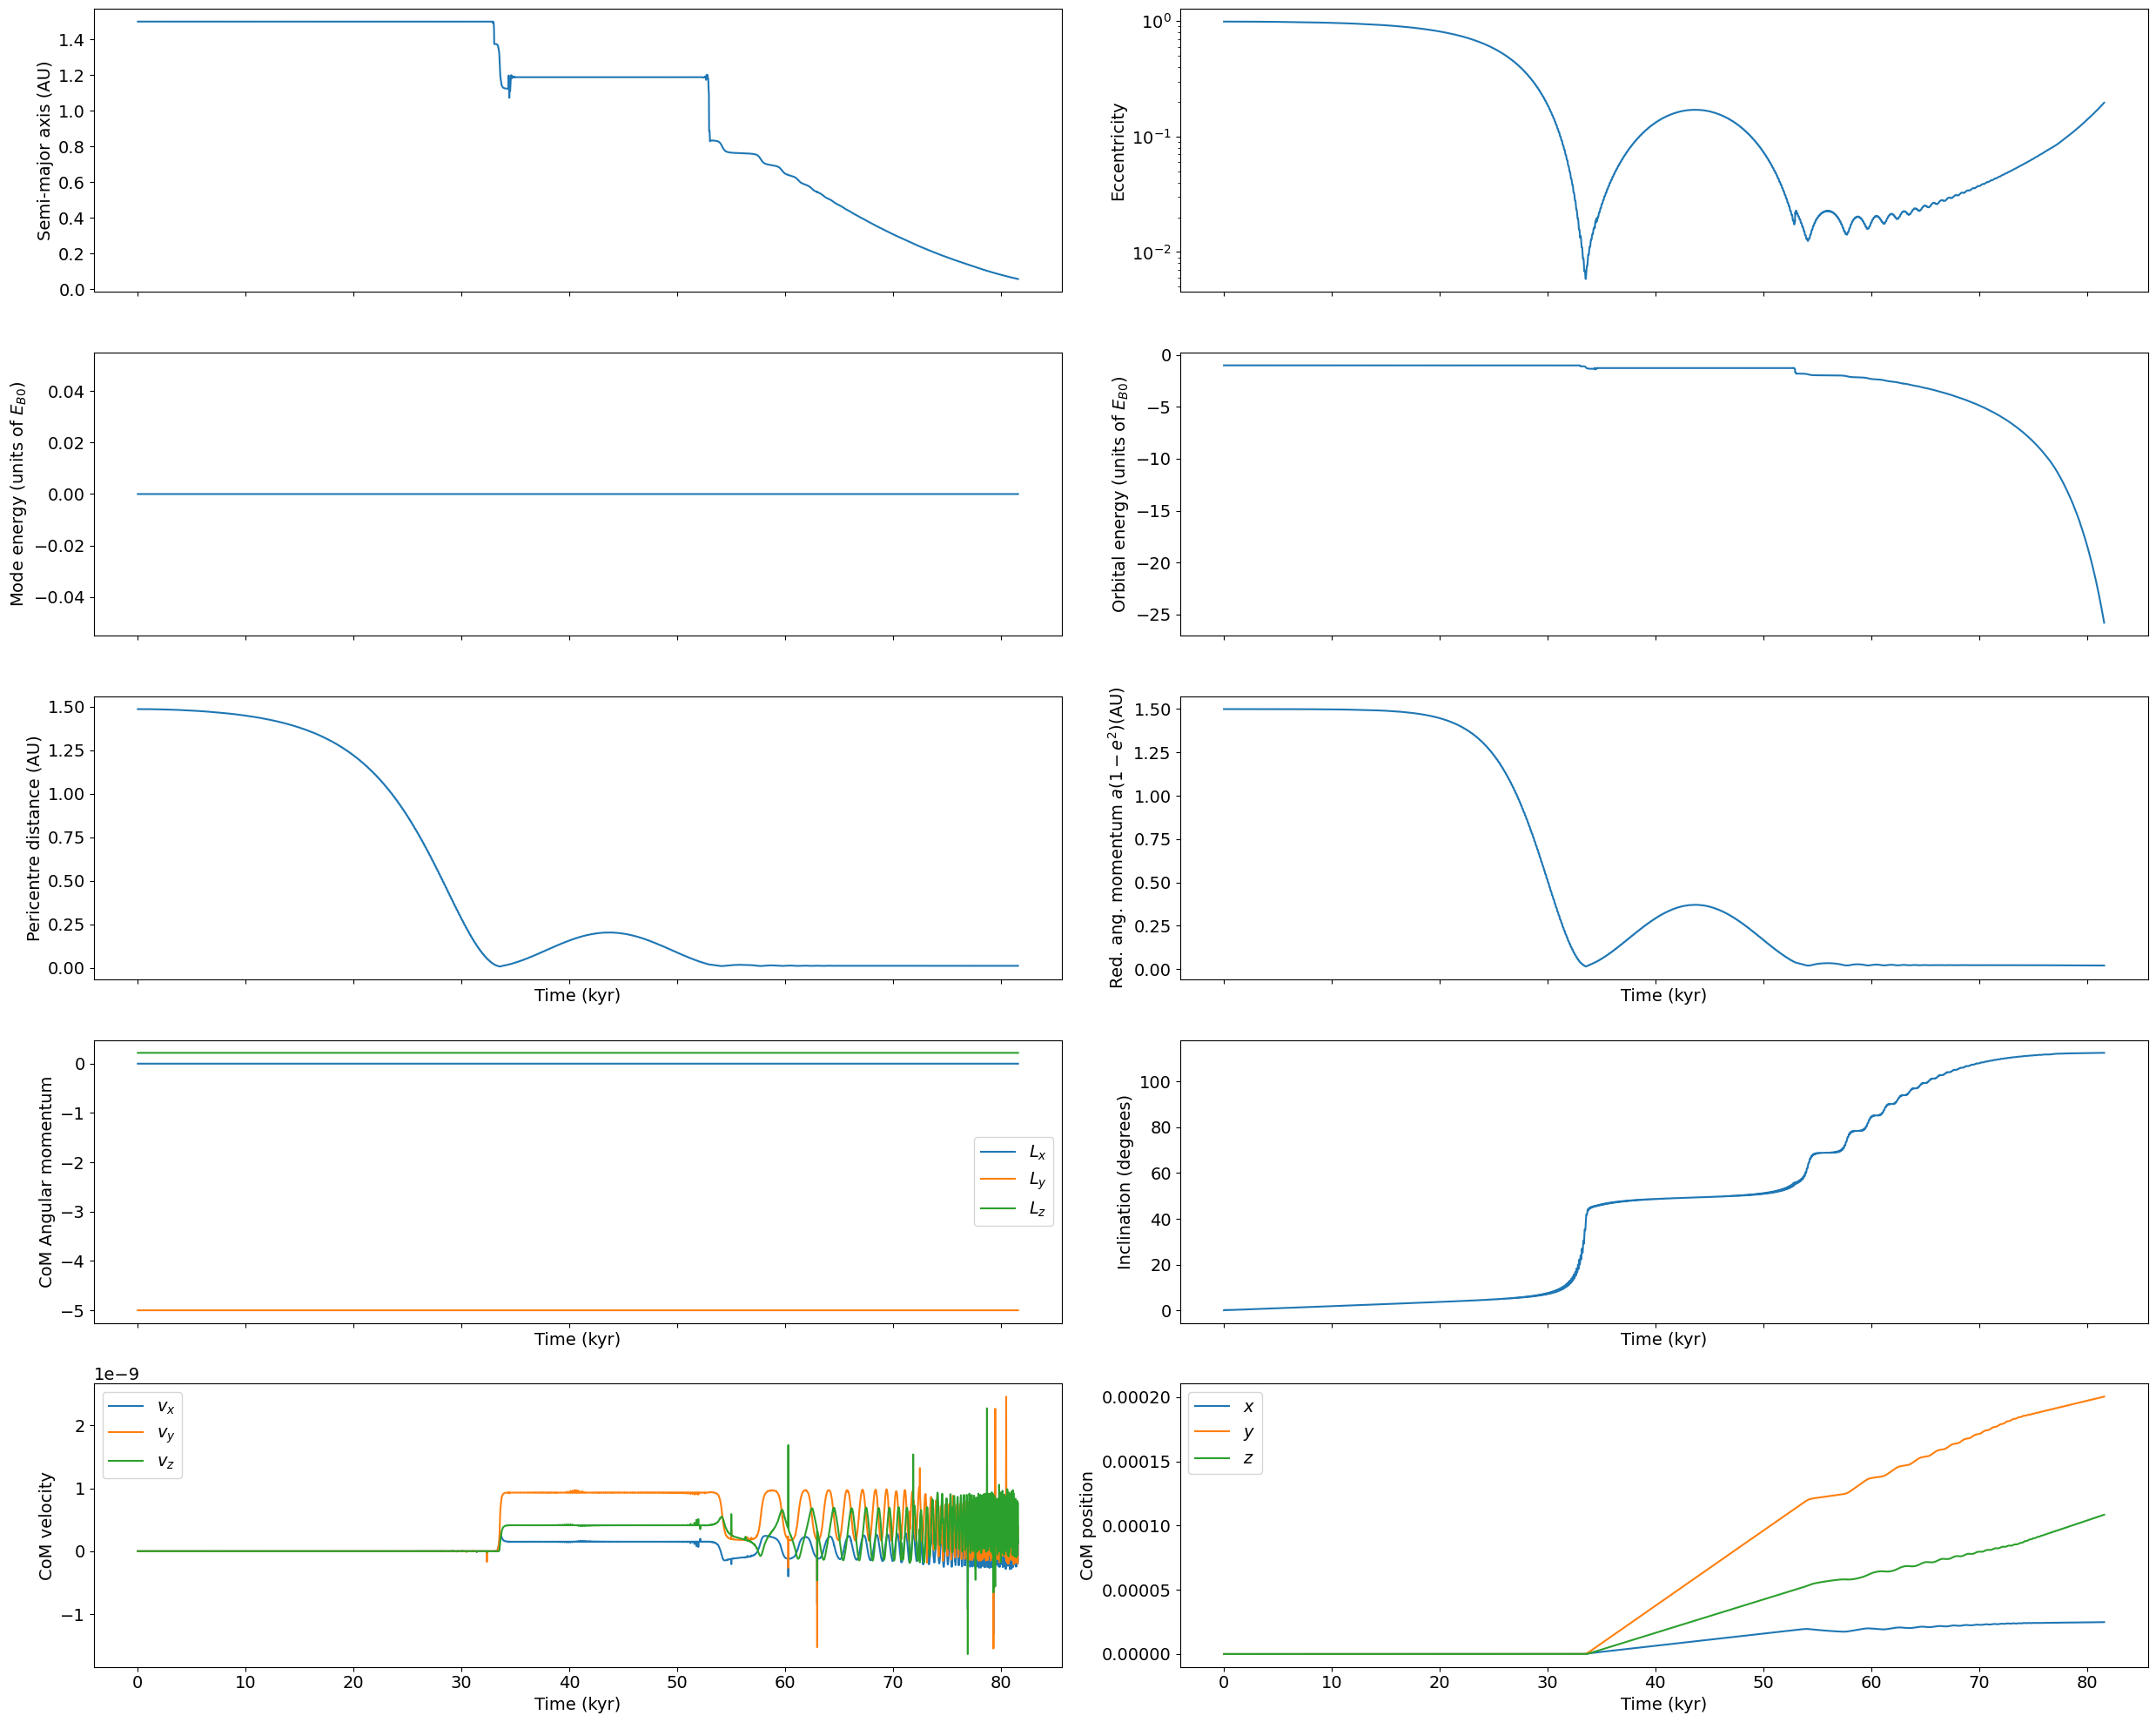

In [5]:
fig, axes = plt.subplots(5, 2, sharex=True)
fig.set_figheight(20)
fig.set_figwidth(25)

indices = np.logical_and(np.logical_and(e != 0, t >= 0), t<=2e5)


#axes[0, 0].plot(t[indices] / 1e3, a[indices])
axes[0, 0].plot(t[indices] / 1e3, a[indices])
axes[0, 0].set_ylabel(r'Semi-major axis (AU)')

axes[0, 1].plot(t[indices] / 1e3, 1 - e[indices])
axes[0, 1].set_yscale("log")
axes[0, 1].set_ylabel(r'Eccentricity')

axes[1, 0].plot(t[indices] / 1e3, -E[indices] / EB0)
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B0}$)')

axes[1, 1].plot(t[indices] / 1e3, (sim.particles[1].m / (2*a[indices]))/ EB0)
axes[1, 1].set_ylabel(r'Orbital energy (units of $E_{B0}$)')

axes[2, 0].plot(t[indices] / 1e3, a[indices] * (1-e[indices]))
axes[2, 0].set_ylabel(r'Pericentre distance (AU)')
axes[2, 0].set_xlabel(r'Time (kyr)')

axes[2, 1].plot(t[indices] / 1e3, a[indices] * (1-e[indices]**2))
axes[2, 1].set_ylabel(r'Red. ang. momentum $a(1-e^2)$(AU)')
axes[2, 1].set_xlabel(r'Time (kyr)')

axes[3, 1].plot(t[indices] / 1e3, inc1[indices] * 180 / np.pi)
axes[3, 1].set_ylabel(r'Inclination (degrees)')
axes[3, 1].set_xlabel(r'Time (kyr)')

axes[3, 0].plot(t[indices] / 1e3, L[:,0][indices], label=r'$L_x$')
axes[3, 0].plot(t[indices] / 1e3, L[:,1][indices], label=r'$L_y$')
axes[3, 0].plot(t[indices] / 1e3, L[:,2][indices], label=r'$L_z$')
axes[3, 0].set_ylabel('CoM Angular momentum')
axes[3, 0].legend()
axes[3, 0].set_xlabel(r'Time (kyr)')

axes[4, 0].plot(t[indices] / 1e3, comv[:,0][indices], label=r'$v_x$')
axes[4, 0].plot(t[indices] / 1e3, comv[:,1][indices], label=r'$v_y$')
axes[4, 0].plot(t[indices] / 1e3, comv[:,2][indices], label=r'$v_z$')
axes[4, 0].set_ylabel('CoM velocity')
axes[4, 0].legend()
axes[4, 0].set_xlabel(r'Time (kyr)')

axes[4, 1].plot(t[indices] / 1e3, comr[:,0][indices], label=r'$x$')
axes[4, 1].plot(t[indices] / 1e3, comr[:,1][indices], label=r'$y$')
axes[4, 1].plot(t[indices] / 1e3, comr[:,2][indices], label=r'$z$')
axes[4, 1].set_ylabel('CoM position')
axes[4, 1].legend()
axes[4, 1].set_xlabel(r'Time (kyr)')


plt.tight_layout()
#plt.savefig("ET Kozai ab50.png", dpi=150)

In [5]:
import pickle

#with open("Kozai ab50 ET.pickle", "wb") as f:
#    pickle.dump([t, a, a2, e2, e, E, E_sim, L, L0, L1, L2, L_manual, comr, comv, inc1, inc2], f)

In [13]:
with open("Kozai ab50 ET.pickle", "rb") as f:
    t_ET, a_ET, _, _, e_ET, E_ET, _, _, _, _, _, _, _, _, _, inc_ET = pickle.load(f)
with open("Kozai ab50 DT.pickle", "rb") as f:
    t_DT, a_DT, _, _, e_DT, E_DT, _, _, _, _, _, _, _, _, _, inc_DT = pickle.load(f)

In [17]:
inc_DT * 180 / np.pi

array([84.27683029, 84.27683029, 84.49229259, ...,  0.        ,
        0.        ,  0.        ], shape=(10000,))

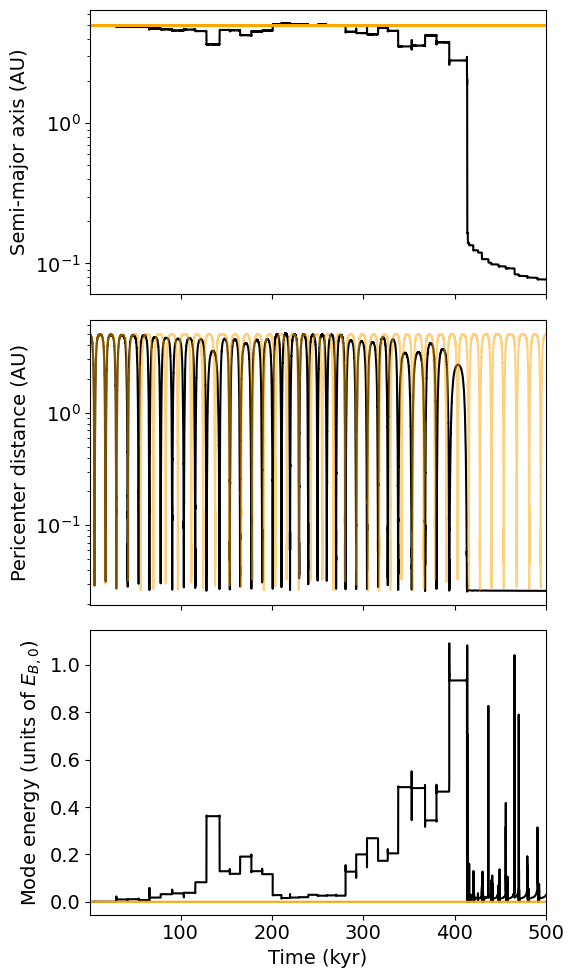

In [66]:
indices_ET = np.logical_and(np.logical_and(e_ET != 0, t_ET >= 0), t_ET<=2.125e6)
indices_DT = np.logical_and(np.logical_and(e_DT != 0, t_DT >= 0), t_DT<=2.125e6)

fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(6)

axes[0].plot(t_DT[indices_DT] / 1e3, a_DT[indices_DT], c='black')
axes[0].plot(t_ET[indices_ET] / 1e3, a_ET[indices_ET], c='orange')
axes[0].set_yscale("log")
#axes[0, 0].set_xscale("log")
axes[0].set_xlim([1, 5e2])
axes[0].set_ylabel(r'Semi-major axis (AU)')

#axes[0, 1].plot(t_DT[indices_DT] / 1e3, 1 - e_DT[indices_DT], c='black', alpha=1)
#axes[0, 1].plot(t_ET[indices_ET] / 1e3, 1 - e_ET[indices_ET], c='orange', alpha=0.5)
#axes[0, 1].set_yscale("log")
#axes[0, 1].set_xscale("log")
#axes[0, 1].set_xlim([1, 5e2])
#axes[0, 1].set_ylabel(r'Eccentricity')

axes[1].plot(t_DT[indices_DT] / 1e3, a_DT[indices_DT] * (1 - e_DT[indices_DT]), c='black', alpha=1)
axes[1].plot(t_ET[indices_ET] / 1e3, a_ET[indices_ET] * (1 - e_ET[indices_ET]), c='orange', alpha=0.5)
axes[1].set_ylabel(r'Pericenter distance (AU)')
axes[1].set_yscale("log")

axes[2].plot(t_DT[indices_DT] / 1e3, E_DT[indices_DT] / -EB0, c='black', alpha=1)
axes[2].plot(t_ET[indices_ET] / 1e3, E_ET[indices_ET] / -EB0, c='orange', alpha=1)
#axes[1, 0].set_xscale("log")
axes[2].set_xlim([1, 5e2])
axes[2].set_ylabel(r'Mode energy (units of $E_{B,0}$)')
axes[2].set_xlabel(r'Time (kyr)')

plt.tight_layout()
plt.savefig("DT vs. ET ab50 inc84.5.png", dpi=150)

In [25]:
len(t_ET)

10000

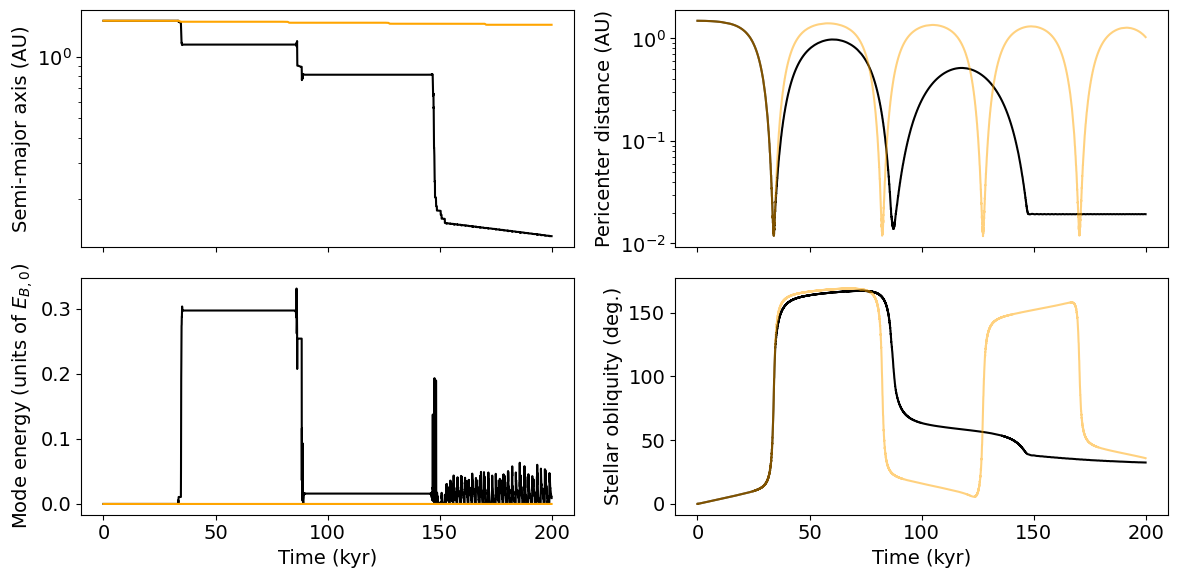

In [21]:
with open("Kozai ab50 ET.pickle", "rb") as f:
    t_ET, a_ET, _, _, e_ET, E_ET, _, _, _, _, _, _, _, _, inc1_ET, inc2_ET = pickle.load(f)
with open("Kozai ab50 DT.pickle", "rb") as f:
    t_DT, a_DT, _, _, e_DT, E_DT, _, _, _, _, _, _, _, _, inc1_DT, inc2_DT = pickle.load(f)

indices_ET = np.logical_and(np.logical_and(e_ET != 0, t_ET >= 0), t_ET<=2e5)
indices_DT = np.logical_and(np.logical_and(e_DT != 0, t_DT >= 0), t_DT<=2e5)

fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_figheight(6)
fig.set_figwidth(12)

axes[0, 0].plot(t_DT[indices_DT] / 1e3, a_DT[indices_DT], c='black')
axes[0, 0].plot(t_ET[indices_ET] / 1e3, a_ET[indices_ET], c='orange')
axes[0, 0].set_yscale("log")
#axes[0, 0].set_xscale("log")
#axes[0].set_xlim([1, 5e2])
axes[0, 0].set_ylabel(r'Semi-major axis (AU)')

#axes[0, 1].plot(t_DT[indices_DT] / 1e3, 1 - e_DT[indices_DT], c='black', alpha=1)
#axes[0, 1].plot(t_ET[indices_ET] / 1e3, 1 - e_ET[indices_ET], c='orange', alpha=0.5)
#axes[0, 1].set_yscale("log")
#axes[0, 1].set_xscale("log")
#axes[0, 1].set_xlim([1, 5e2])
#axes[0, 1].set_ylabel(r'Eccentricity')

axes[0, 1].plot(t_DT[indices_DT] / 1e3, a_DT[indices_DT] * (1 - e_DT[indices_DT]), c='black', alpha=1)
axes[0, 1].plot(t_ET[indices_ET] / 1e3, a_ET[indices_ET] * (1 - e_ET[indices_ET]), c='orange', alpha=0.5)
axes[0, 1].set_ylabel(r'Pericenter distance (AU)')
axes[0, 1].set_yscale("log")

axes[1, 0].plot(t_DT[indices_DT] / 1e3, E_DT[indices_DT] / -EB0, c='black', alpha=1)
axes[1, 0].plot(t_ET[indices_ET] / 1e3, E_ET[indices_ET] / -EB0, c='orange', alpha=1)
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B,0}$)')
axes[1, 0].set_xlabel(r'Time (kyr)')

axes[1, 1].plot(t_DT[indices_DT] / 1e3, np.abs(inc1_DT[indices_DT] * (180/np.pi)), c='black', alpha=1)
axes[1, 1].plot(t_ET[indices_ET] / 1e3, np.abs(inc1_ET[indices_ET] * (180/np.pi)), c='orange', alpha=0.5)
axes[1, 1].set_xlabel(r'Time (kyr)')
axes[1, 1].set_ylabel(r'Stellar obliquity (deg.)')

plt.tight_layout()
plt.savefig("DT vs. ET ab50 inc84.5.png", dpi=150)